Давайте попробуем поизучать сезонность торговых инстументов.
Возьмем, например, EURUSD
Экспортируем из метатрейдера дневной график, он там доступен с ноября 2002 года. 
В принципе, можно экспортировать любой ТФ, но для анализа сезонности нам должно быть достаточно дневных движений
Разметим колонки в файле, как DATE, TIME, OPEN, HIGH, LOW, CLOSE, VOLUME - именно в таком порядке данные расположены в файле выдачи экспорта истории метатрейдера.
Давайте зачитаем его в табличку:

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('Dukascopy-JPNIDXJPY-2011.09.18-2025.02.05-bardata_D1.csv',
                 sep=',',
                 header=0,
                 dtype={
                     'Open': np.float64,
                     'High': np.float64,
                     'Low': np.float64,
                     'Close': np.float64},
                 encoding='utf-8',
                 parse_dates=['Date'],
                 date_format='%Y.%m.%d').set_index('Date') 
df.head(5)

,Open,High,Low,Close
Date,,,,
2011-09-19,8864.16,8864.16,8864.16,8864.16
2011-09-20,8864.16,8864.16,8704.23,8721.24
2011-09-21,8717.00,8771.62,8707.28,8741.16
2011-09-22,8643.02,8643.02,8545.46,8560.26
2011-09-23,8560.26,8560.26,8560.26,8560.26


Нам не очень нужны все эти колонки для анализа.
Все, что нам нужно - это величина тела свечи, положительная для бычьих свечей и отрицательная - для медвежьих.
Для чистоты данных, мы будем считать тело свечи, как разницу между предыдущим и текущим закрытием.
Попутно вычистим неполные годы. Для порядку.

In [2]:
# Calculate the difference between consecutive CLOSE values
df['MOVE'] = df['Close'].diff()
# Handle the first row
df.loc[df.index[0], 'MOVE'] = df.loc[df.index[0], 'Close'] - df.loc[df.index[0], 'Open']

# Get the start and end years
start_year = df.index[0].year
end_year = df.index[-1].year

# Check if the start date is after January 10th
if df.index[0] > datetime(start_year, 1, 10):
    start_year += 1

# Check if the end date is before December 20th
if df.index[-1] < datetime(end_year, 12, 20):
    end_year -= 1

# Truncate the dataframe
df_trimmed = df[['MOVE']].copy().truncate(before=datetime(start_year, 1, 1), after=datetime(end_year, 12, 31))

df_trimmed.head(5)

,MOVE
Date,
2012-02-06,368.94
2012-02-07,-11.68
2012-02-08,98.07
2012-02-09,-13.35
2012-02-10,-55.07


Стало гораздо приятнее, правда?
Нарисуем это добро на графичке:

Matplotlib is building the font cache; this may take a moment.


<Axes: xlabel='Date'>

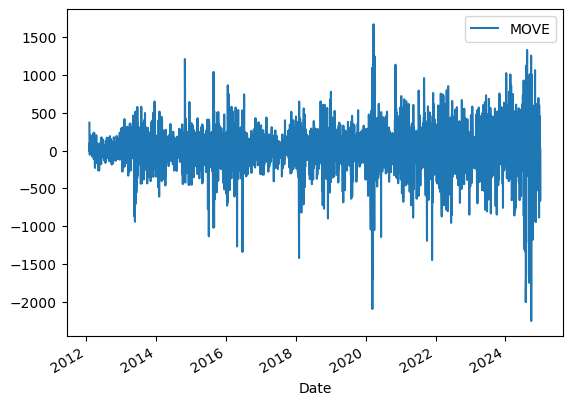

In [3]:
import matplotlib
df_trimmed.plot()

Теперь нам нужно порезать это все на месяцы (чтобы данные одного месяца не сравнивать с данными другого месяца в разные годы, что может случиться за счет разного рода выходных) и сгруппировать по годам:

In [4]:
years = df_trimmed.index.year.unique()
new_index = pd.date_range(start=f'{min(years)}-01-01', end=f'{max(years)}-12-31', freq='D')
df_reindexed = df_trimmed.reindex(new_index).fillna(0.0)
pivot_by_year = df_reindexed.pivot_table(
    index=[df_reindexed.index.month, df_reindexed.index.day],
    columns=df_reindexed.index.year, 
    values='MOVE',
    aggfunc='first').fillna(0.0)  # this fillna is for aligning with leap year
pivot_by_year.head(10)

2012    2013     2014     2015     2016     2017     2018     2019  \
1 1    0.0    0.00    0.001    0.000    0.000    0.000    0.000    0.000   
  2    0.0    0.00 -345.000   16.000    0.000    0.000   79.999   -5.000   
  3    0.0    0.00   81.999    0.000    0.000  260.001  385.000 -418.499   
  4    0.0  292.93    0.000    0.000 -570.000  335.000  451.000  779.000   
  5    0.0    0.00    0.000 -297.000  135.000 -208.001  149.500    0.000   
  6    0.0    0.00 -253.999 -405.002 -388.002  157.500    0.000    0.000   
  7    0.0  -89.10  122.000  309.000 -435.998    0.000    0.000   84.500   
  8    0.0  -90.95   86.999  363.000 -315.000    0.000  137.500   96.500   
  9    0.0   70.51 -108.000 -452.998    0.000 -162.500  -93.500    0.000   
  10   0.0   74.07  -68.000    0.000    0.000 -112.500 -239.500   18.000   

        2020    2021    2022    2023     2024  
1 1     0.00    0.00    0.00    0.00     0.00  
  2   219.95    0.00    0.00    0.00  -195.25  
  3  -384.95    0.00   56.27   -4.90   -25.80  
  4     0.00 -382.95  350.00   55.00   264.00  
  5     0.00   32.05 -274.90 -142.00   113.05  
  6    50.58  210.10 -294.37  470.00     0.00  
  7    49.52  257.95 -285.58    0.00     0.00  
  8    89.85  722.05    0.00    0.00   449.75  
  9   288.95    0.00    0.00   24.95   -11.27  
  10  -71.90    0.00 -257.10   78.10  1025.42

<Axes: >

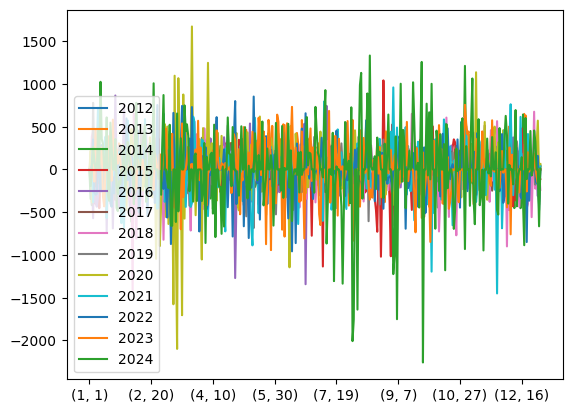

In [5]:
pivot_by_year.plot()

В нашей табличке с пивотом теперь есть колонка с номером месяца и колонка с номером дня месяца - обе входят в индекс - а также колонка для каждого года, в которую записан размер тела свечи с соответствующим знаком в этот день этого месяца этого года.
В целом, данные уже можно проанализировать на корреляцию
Давайте полюбопытствуем


In [6]:
import scipy

correlation_matrix = pivot_by_year.corr().dropna(how='all').dropna(axis=1, how='all')
correlation_matrix.head(50)

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
2012,1.000000,-0.001518,0.043358,0.020304,0.044208,-0.141298,0.105805,0.059582,-0.080898,-0.051892,0.124333,0.087780,0.017147
2013,-0.001518,1.000000,0.002742,-0.065940,0.065512,-0.017016,0.069441,0.095534,0.047685,-0.016118,-0.038427,0.048556,-0.074492
2014,0.043358,0.002742,1.000000,-0.020990,0.005988,0.080716,-0.004875,-0.115164,0.001385,-0.060647,0.027121,0.051672,0.012219
2015,0.020304,-0.065940,-0.020990,1.000000,-0.003472,0.044333,-0.048866,0.053907,-0.047522,0.026129,-0.052980,-0.029968,0.063104
2016,0.044208,0.065512,0.005988,-0.003472,1.000000,-0.034853,-0.047383,-0.063360,-0.039947,-0.056009,-0.020213,-0.066120,-0.038206
2017,-0.141298,-0.017016,0.080716,0.044333,-0.034853,1.000000,-0.029249,0.001233,0.027649,0.097369,-0.045065,-0.101434,0.016473
2018,0.105805,0.069441,-0.004875,-0.048866,-0.047383,-0.029249,1.000000,0.002698,-0.057832,-0.031300,0.022102,0.055828,-0.098112
2019,0.059582,0.095534,-0.115164,0.053907,-0.063360,0.001233,0.002698,1.000000,-0.061049,0.012998,-0.024494,0.009821,0.151179
2020,-0.080898,0.047685,0.001385,-0.047522,-0.039947,0.027649,-0.057832,-0.061049,1.000000,-0.113314,-0.094560,-0.039501,0.000398
2021,-0.051892,-0.016118,-0.060647,0.026129,-0.056009,0.097369,-0.031300,0.012998,-0.113314,1.000000,-0.098158,-0.049594,-0.021556


Так, разумеется, ничего не понятно, поэтому мы возьмем верхний треугольник и посчитаем среднюю степень корреляции по годам:

In [7]:
upper_triangle = correlation_matrix.values[np.triu_indices(len(correlation_matrix), k=1)]
average_correlation = np.mean(upper_triangle)
average_correlation

np.float64(-0.0060061245707417775)

очень близка к нулю, говорит.
Ну мы не удовлетворимся. Обратимся к z-трансформации Фишера, потому что усреднение корреляций - так себе идея

In [8]:
z_values = np.arctanh(upper_triangle)
mean_z = np.mean(z_values)
average_correlation = np.tanh(mean_z)
average_correlation

np.float64(-0.00601235708289994)

Еще хуже. Ну окей, на протяжении всего года корреляция стремится к нулю за последние 20 лет
А давайте, может, поищем интервалы внутри года, где она к нулю не стремится?
<b>Сразу предупрежу: в этот момент мы начинаем подыскивать подтверждение нашей исходной теории после того, как она была опровергнута в целом. Это называется подгонка фактов под теорию, в народе известная, как cherry-picking</b>
<br>
Для начала избавимся от понятия месяц и день - ну не нужны они нам объективно. Просто пронумеруем день в году.

In [9]:
len(pivot_by_year)

366

In [20]:
pivot_reset = pivot_by_year.reset_index(drop=True)
pivot_reset.tail(10)

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
356,0.00,0.000,62.000,37.002,-35.001,65.001,0.000,0.000,43.58,29.90,-365.10,-25.15,0.000
357,0.00,127.000,88.000,204.998,5.000,0.000,0.000,-15.000,109.42,154.20,154.85,0.00,449.949
358,0.00,-170.000,-38.002,-278.000,0.000,0.000,-557.500,-30.001,-31.42,0.00,0.00,0.00,-70.949
359,140.06,144.969,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.00,0.00,0.000
360,150.24,211.031,83.000,0.000,0.000,7.000,675.501,170.000,0.00,0.00,0.00,187.10,455.847
361,92.62,44.999,0.000,0.000,0.000,5.000,-225.001,-177.649,0.00,140.90,-17.75,13.95,327.051
362,72.20,0.000,0.000,35.000,-94.499,-131.000,232.001,0.000,291.37,14.85,-156.52,-83.10,0.000
363,0.00,0.000,-176.998,225.002,-312.501,-48.000,0.000,0.000,571.15,-180.27,158.52,-154.75,0.000
364,0.00,0.000,-411.000,-135.002,32.000,0.000,0.000,-374.900,-83.25,2.32,-477.15,0.00,-664.898
365,0.00,38.000,49.000,-113.998,0.000,0.000,-238.001,35.000,65.00,35.68,0.00,0.00,11.949


In [11]:
len(pivot_reset)

366

Определим фитнесс-функцию как среднюю корреляцию суб-матрицы с некоторого одного дня по некоторый другой. По Фишеру.

In [12]:
def fitness_function(df, start_index, end_index):
    # Slice the DataFrame based on the given indices
    df_slice = df.iloc[start_index:end_index+1]
    
    # Calculate the correlation matrix
    corr_matrix = df_slice.corr().dropna(how='all').dropna(axis=1, how='all')
    
    # Extract the upper triangle of the correlation matrix
    upper_triangle = corr_matrix.values[np.triu_indices(len(corr_matrix), k=1)]
        # Apply Fisher's z-transformation
    z_values = np.arctanh(upper_triangle)
    
    # Calculate the mean of z-values
    mean_z = np.mean(z_values)
    
    # Transform back to correlation coefficient
    average_corr = np.tanh(mean_z)
    
    return average_corr

Протестируем нашу фитнес-функцию на уже известной величине: средней корреляции от начала и до конца года

In [13]:
fitness_function(pivot_reset, 0, len(pivot_reset))

np.float64(-0.00601235708289994)

Совпало, отлично. Давайте накрутим оптимизацию, которая выберет нам оптимальные значения индексов?

In [14]:
import pandas as pd
import numpy as np

def find_optimal_intervals(df, fitness_function):
    n = len(df)
    max_interval_size = n // 2
    best_intervals = []
    best_fitness = 0

    for interval_size in range(2, max_interval_size + 1):
        intervals = []
        for start in range(0, n - interval_size + 1):
            end = start + interval_size - 1
            fitness = fitness_function(df, start, end)
            intervals.append((start, end, fitness))
        
        intervals.sort(key=lambda x: x[2], reverse=True)
        selected = []
        
        for interval in intervals:
            if not any(overlaps(interval, selected_interval) for selected_interval in selected):
                selected.append(interval)
        
        avg_fitness = sum(interval[2] for interval in selected) / len(selected)
        if avg_fitness > best_fitness:
            best_fitness = avg_fitness
            best_intervals = selected

    # Convert the best intervals to a DataFrame
    result_df = pd.DataFrame(best_intervals, columns=['Start', 'End', 'Fitness'])
    result_df['Length'] = result_df['End'] - result_df['Start'] + 1
    result_df = result_df.sort_values('Start').reset_index(drop=True)

    return result_df

def overlaps(interval1, interval2):
    return max(interval1[0], interval2[0]) <= min(interval1[1], interval2[1])

def find_highest_correlation_interval(df, ff, min_interval):
    n = len(df)
    best_start = 0
    best_end = n - 1
    best_correlation = ff(df, best_start, best_end)

    for start in range(n - min_interval):
        for end in range(start + min_interval, n):
            correlation = ff(df, start, end)
            if correlation > best_correlation or np.isnan(best_correlation):
                best_correlation = correlation
                best_start = start
                best_end = end

    return best_start, best_end, best_correlation


Тут, собственно, реализован алгоритм поиска непересекающихся интервалов, жадная вариация.
Он возвращает набор интервалов, отсортированный по убыванию корреляции за все годы.
Натравим его на нашу табличку, попросим :

In [19]:
intervals = find_optimal_intervals(pivot_reset, fitness_function)
# Sort the DataFrame by the 'Fitness' column in descending order
sorted_df = intervals.sort_values('Fitness', ascending=False)
sorted_df.head(10)

# best_start, best_end, best_correlation = find_highest_correlation_interval(pivot_reset, fitness_function, 5)
# print(f"Best interval: [{best_start}, {best_end}] with correlation: {best_correlation}")

,Start,End,Fitness,Length
55,357,361,0.453696,5
25,156,160,0.237346,5
10,58,62,0.202757,5
24,149,153,0.190597,5
28,177,181,0.187470,5
39,259,263,0.153090,5
42,278,282,0.138898,5
48,313,317,0.137608,5
4,26,30,0.135662,5
50,323,327,0.124800,5


Неутешительный итог: даже попытки выдать желаемое за действительное не наловили нам ни одного интервала с корреляцией выше 0.21 за последние 20 лет.
Давайте попробуем упростить и забьем на все выходные и прочие нормализации. Просто возьмем последовательности, как они есть.

In [16]:
df_reset_idx = df_trimmed.reset_index()
df_reset_idx['Year'] = df_reset_idx['Date'].dt.year
year_dfs = {year: group['MOVE'].reset_index(drop=True) for year, group in df_reset_idx.groupby('Year')}
df_final = pd.concat(year_dfs, axis=1).fillna(0.0)
df_final.tail(10)

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
250,0.0,0.0,643.002,79.000,159.001,70.000,-276.999,-69.999,29.85,-225.48,-848.95,-256.90,-886.051
251,0.0,0.0,351.998,37.002,-119.000,-30.001,-453.000,18.000,-292.95,414.90,142.20,201.05,601.898
252,0.0,0.0,158.002,204.998,-35.001,65.001,-401.501,-15.000,43.58,29.90,-365.10,-25.15,-112.796
253,0.0,0.0,62.000,-278.000,5.000,7.000,-557.500,-30.001,109.42,154.20,154.85,187.10,449.949
254,0.0,0.0,88.000,35.000,0.000,5.000,675.501,170.000,-31.42,140.90,-17.75,13.95,-70.949
255,0.0,0.0,-38.002,225.002,-94.499,-131.000,-225.001,-177.649,291.37,14.85,-156.52,-83.10,455.847
256,0.0,0.0,83.000,-135.002,-312.501,-48.000,232.001,-374.900,571.15,-180.27,158.52,-154.75,327.051
257,0.0,0.0,-176.998,-113.998,32.000,0.000,-238.001,35.000,-83.25,2.32,-477.15,0.00,-664.898
258,0.0,0.0,-411.000,0.000,0.000,0.000,0.000,0.000,65.00,35.68,0.00,0.00,11.949
259,0.0,0.0,49.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.00,0.00,0.000


И теперь воспользуемся теми же функциями, которые у нас уже есть

In [17]:
fitness_function(df_final, 0, len(df_final))

np.float64(-0.008477828806222457)

In [18]:
best_start, best_end, best_correlation = find_highest_correlation_interval(df_final, fitness_function, 5)
print(f"Best interval: [{best_start}, {best_end}] with correlation: {best_correlation}")

Best interval: [29, 34] with correlation: 0.15941087192826883


Тут получилось еще хуже, ожидаемо